<a href="https://colab.research.google.com/github/yusuflanre/Image-CNN-Lab/blob/main/CNN_Lab_Transfer_Learning_Filter_Viz_Saliency_Maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image CNN Lab: Transfer Learning, Filter Visualization, Saliency Maps

#### Data Needed

- Download the 10 monkey dataset from Kaggle Competition website https://www.kaggle.com/slothkong/10-monkey-species

- Upload the zipped file in Colab

- Uncompress all content and put it in a directory "10-monkey-species/"

#### Packages Needed

You may need to install the package h5py (if not already installed).

#### Transfer Learning

The objective here is to load a pretrained image classifier like VGG, chop off the top layer and freeze all weights in the remaining VGG network, add a new top layer with trainable weights, and retrain it for a new image classification task to distinguish 10 types of monkey.  

VGG is a large and complex network, however, note that we explicitly set all of the reused layers of VGG to be non-trainable, substantially decreasing the number of weights to train (from 14,849,000 down to 133,000) and hence the amount of data required to train it. 

#### Visualization

In this section, we demonstrate two types of visualization possible with convolution networks:

1. **Visualizing filters:** In this case we select a filter (convolutional channel at a given layer) and do backprop to optimize an input image to maximize the filter activation.

2. **Saliency maps:** Here we show clipped gradients of the input w.r.t. the true label for an image in order to find the part of the input most responsible for the classification.  It is noisy but it does tend to highlight key regions of the image responsible for the classification.

## Transfer Learning

### Packages

In [ ]:
import cv2
import datetime as dt
import glob
import itertools
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from tensorflow.python.keras import models, layers, optimizers
from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.python.keras.applications import Xception, VGG16
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
from tensorflow.python.keras.models import Model
from sklearn.metrics import confusion_matrix

from tensorflow.python.keras import backend as K
K.set_learning_phase(1)

from imageio import imwrite

### Unzipping the compressed data

In [ ]:
#import zipfile
#zip_ref = zipfile.ZipFile("10-monkey-species.zip", "r")
#zip_ref.extractall("10-monkey-species----")
#zip_ref.close()

In [ ]:
! mkdir 10-monkey-species
! unzip 10-monkey-species.zip -d 10-monkey-species

Archive:  10-monkey-species.zip
  inflating: 10-monkey-species/monkey_labels.txt  
  inflating: 10-monkey-species/training/training/n0/n0018.jpg  
  inflating: 10-monkey-species/training/training/n0/n0019.jpg  
  inflating: 10-monkey-species/training/training/n0/n0020.jpg  
  inflating: 10-monkey-species/training/training/n0/n0021.jpg  
  inflating: 10-monkey-species/training/training/n0/n0022.jpg  
  inflating: 10-monkey-species/training/training/n0/n0023.jpg  
  inflating: 10-monkey-species/training/training/n0/n0024.jpg  
  inflating: 10-monkey-species/training/training/n0/n0025.jpg  
  inflating: 10-monkey-species/training/training/n0/n0026.jpg  
  inflating: 10-monkey-species/training/training/n0/n0027.jpg  
  inflating: 10-monkey-species/training/training/n0/n0028.jpg  
  inflating: 10-monkey-species/training/training/n0/n0029.jpg  
  inflating: 10-monkey-species/training/training/n0/n0030.jpg  
  inflating: 10-monkey-species/training/training/n0/n0031.jpg  
  inflating: 10-monke

### Load and Visualize Data

You need to change the `data_dir` to the directory in your google drive where you have uploaded the data.

In [ ]:
data_dir = "10-monkey-species"
train_dir = data_dir + '/training/training'
test_dir = data_dir + '/validation/validation'

In [ ]:
train_dir

'10-monkey-species/training/training'

In [ ]:
#label info
cols = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
labels = pd.read_csv(data_dir + '/monkey_labels.txt', names=cols, skiprows=1)
labels

Label                Latin Name  ... Train Images  Validation Images
0  n0         alouatta_palliata\t   ...          131                 26
1  n1        erythrocebus_patas\t   ...          139                 28
2  n2        cacajao_calvus\t       ...          137                 27
3  n3        macaca_fuscata\t       ...          152                 30
4  n4       cebuella_pygmea\t       ...          131                 26
5  n5       cebus_capucinus\t       ...          141                 28
6  n6       mico_argentatus\t       ...          132                 26
7  n7      saimiri_sciureus\t       ...          142                 28
8  n8       aotus_nigriceps\t       ...          133                 27
9  n9       trachypithecus_johnii   ...          132                 26

[10 rows x 5 columns]

(682, 1024, 3)


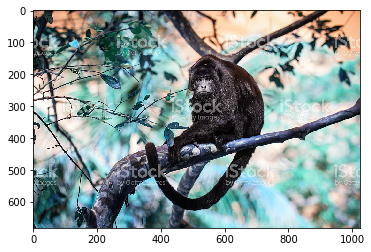

In [ ]:
img = cv2.imread(train_dir + '/n0/n0168.jpg')
print(img.shape)
plt.imshow(img);

In [ ]:
labels = labels['Common Name']
labels

0     mantled_howler                
1     patas_monkey                  
2     bald_uakari                   
3     japanese_macaque              
4     pygmy_marmoset                
5     white_headed_capuchin         
6     silvery_marmoset              
7     common_squirrel_monkey        
8     black_headed_night_monkey     
9     nilgiri_langur                
Name: Common Name, dtype: object

In [ ]:
height=224
width=224
channels=3
batch_size=32
seed=1337


# Training generator
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(height,width),
                                                    batch_size=batch_size,
                                                    seed=seed,
                                                    class_mode='categorical')

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(height,width), 
                                                  batch_size=batch_size,
                                                  seed=seed,
                                                  class_mode='categorical')

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


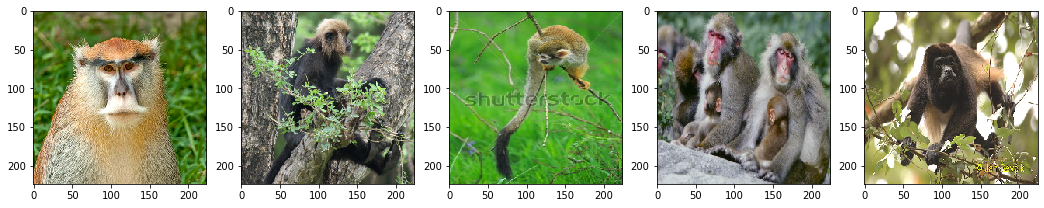

In [ ]:
def show_data(generator, sample_size=5):
    image,_ = train_generator.next()
    plt.figure(figsize=(18, 10))
    reference = image[:sample_size]
    for i in range(reference.shape[0]):
        plt.subplot(int(reference.shape[0]/sample_size)+1, sample_size, i+1)
        plt.imshow(reference[i])
    plt.show()
show_data(train_generator)

### Load Pretrained Model and and Change Top Layers

In [ ]:
# Initialize the base model
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(height, width, channels))

# Fine-tuning layers
x = base_model.output
# See here for motivation for GlobalAveragePooling: 
#   https://alexisbcook.github.io/2017/global-average-pooling-layers-for-object-localization/
# In the following case, rather than flatten, this leads to many fewer outputs/weights
x = GlobalAveragePooling2D()(x) 
x = Dense(256, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x) # Note that we want softmax activation in the last layer
model = Model(inputs=base_model.input, outputs=predictions)

# Set base_model nontrainable
for layer in base_model.layers:
    layer.trainable = False
    
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 1

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit_generator(train_generator, 
                              steps_per_epoch=3, # CHANGE TO 35 
                              epochs=2, # CHANGE TO 30
                              validation_data=test_generator, 
                              validation_steps=10)

Epoch 1/2
3/3 [==============================] - 228s 76s/step - loss: 2.4302 - acc: 0.0938 - val_loss: 2.2798 - val_acc: 0.1086
Epoch 2/2
3/3 [==============================] - 219s 73s/step - loss: 2.1959 - acc: 0.2396 - val_loss: 2.2208 - val_acc: 0.1908


### Training Curves 

**Note:** For your final run, increase epochs and steps_per_epoch as noted above.

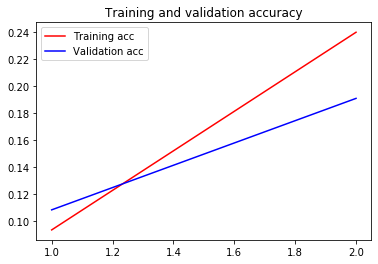

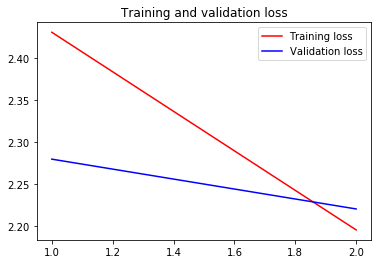

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure()
plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

### Filter Visualization

In [ ]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [ ]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
def filter_visualization(layer_name, sample_size):
    filter_index = 0
    count = 0
    layer_output = layer_dict[layer_name].output
    samples = []
    while count<sample_size and filter_index<32:
        loss = K.mean(layer_output[:, :, :, filter_index])
        grads = K.gradients(loss, model.input)[0]
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
        iterate = K.function([model.input], [loss, grads])
        
        input_img_data = np.random.random((1, 224, 224, 3)) * 20 + 128.
        loss_value = 0
        for i in range(20):
            loss_value, grads_value = iterate([input_img_data])
            input_img_data += grads_value
        if loss_value != 0.0:
            img = input_img_data[0]
            #img[img<0] = 0
            img = deprocess_image(img)
            samples.append(img)
            count += 1
        filter_index += 1
    return samples

In [ ]:
def layerwise_visualization(names):
    for name in names:
        print(name)
        samples = filter_visualization(name, 5)
        plt.figure(figsize=(18, 10))
        reference = np.stack(samples)
        for i in range(reference.shape[0]):
            plt.subplot(int(reference.shape[0]/5)+1, 5, i+1)
            plt.imshow(reference[i])
        plt.show()

In [ ]:
conv_layer_names = [layer.name for layer in model.layers if "conv" in layer.name]

block1_conv1


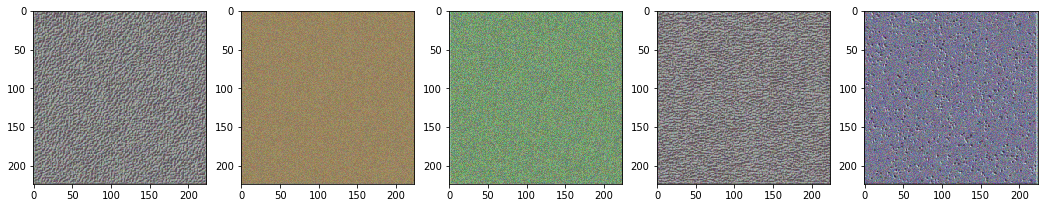

block1_conv2


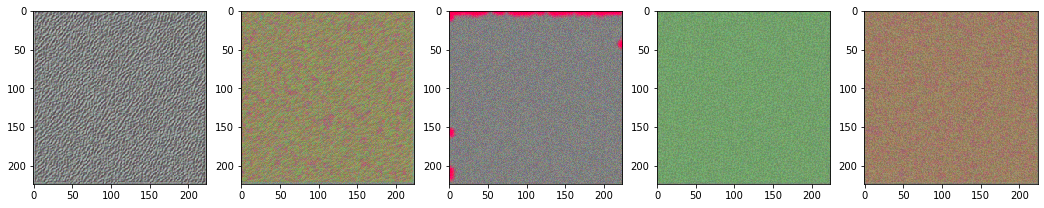

block2_conv1


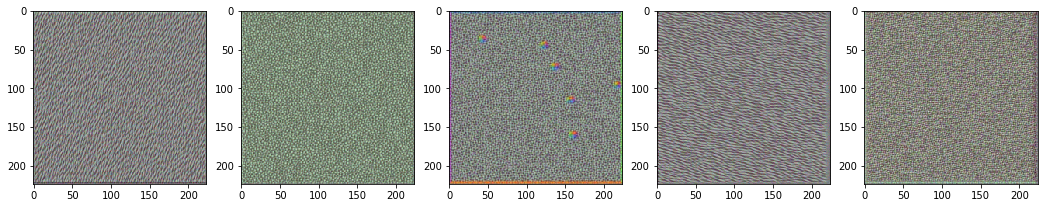

block2_conv2


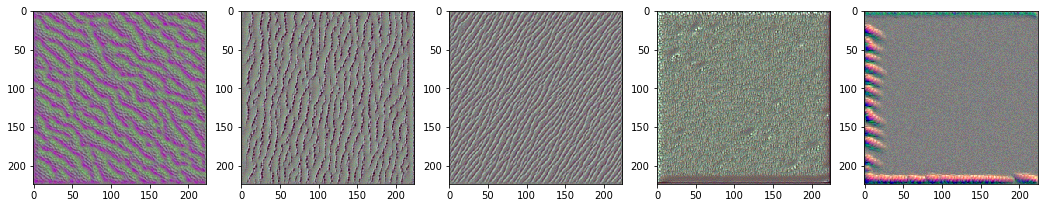

block3_conv1


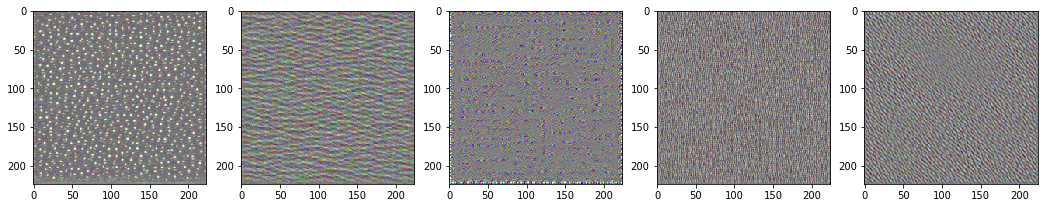

block3_conv2


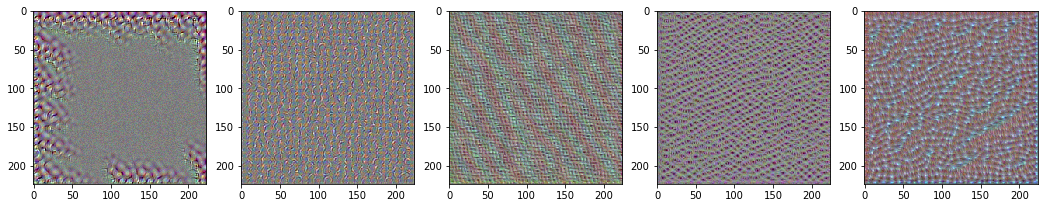

block3_conv3


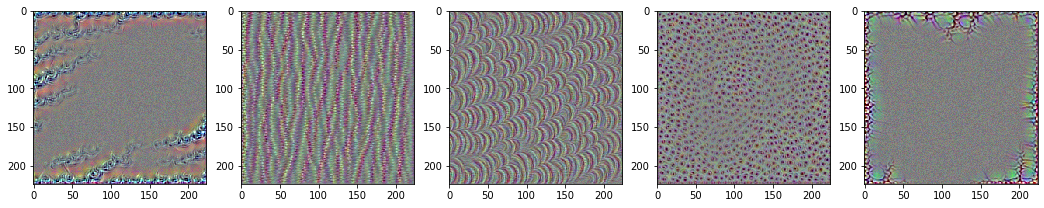

block4_conv1


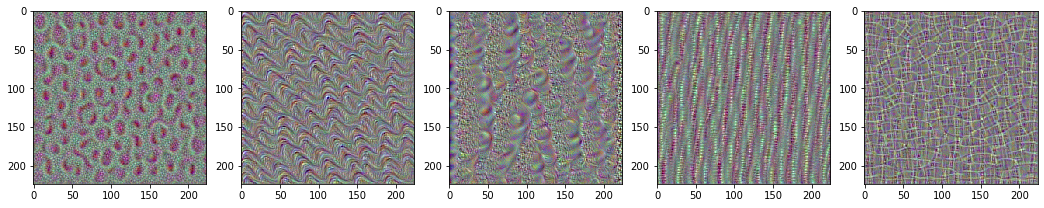

block4_conv2


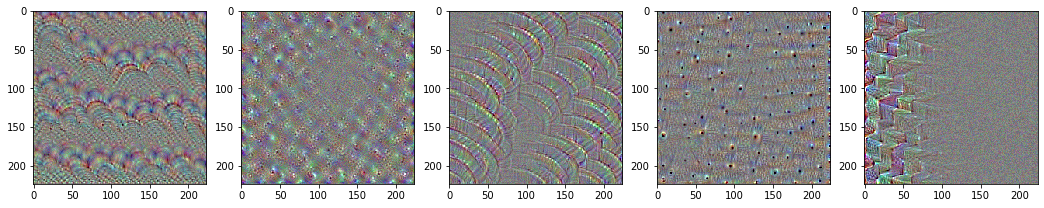

block4_conv3


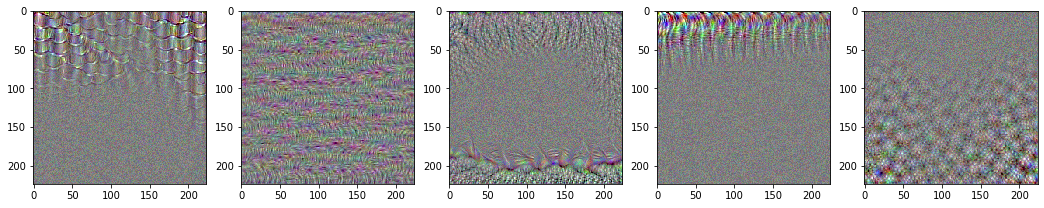

block5_conv1


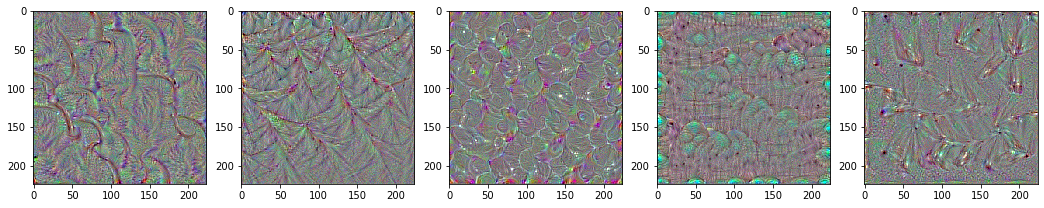

block5_conv2


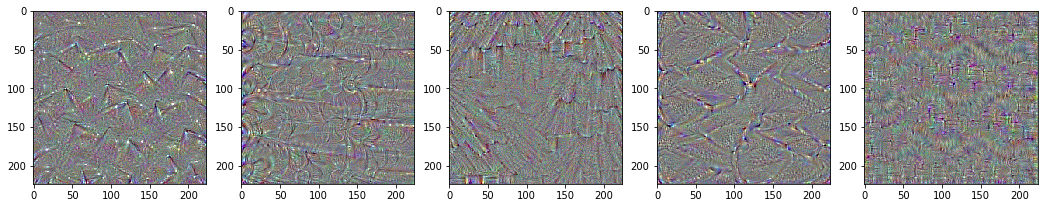

block5_conv3


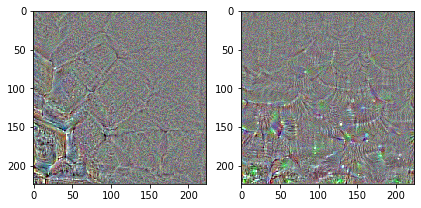

In [ ]:
layerwise_visualization(conv_layer_names)

### Saliency Maps

In [ ]:
class GradientSaliency(object):

    def __init__(self, model, output_index=0):
        input_tensors = [model.input,        # placeholder for input image tensor
                         #K.learning_phase(), # placeholder for mode (train or test) tense
                        ]
        gradients = model.optimizer.get_gradients(model.output[:,output_index], model.input)
        self.compute_gradients = K.function(inputs=input_tensors, outputs=gradients)

    def get_mask(self, input_image):
        
        x_value = np.expand_dims(input_image, axis=0)
        gradients = self.compute_gradients([x_value])[0]

        return gradients

In [ ]:
image, label = train_generator.next()

In [ ]:
def saliency_visualization(data_generator, sample_size=5):
    image, labels = data_generator.next()
    
    plt.figure(figsize=(18, 10))
    reference = image[:sample_size]
    for i in range(reference.shape[0]):
        plt.subplot(int(reference.shape[0]/sample_size)+1, sample_size, i+1)
        plt.imshow(reference[i])
    plt.show()
    
    maps = []
    for i in range(sample_size):
        saliency = GradientSaliency(model, np.argmax(label[i]))
        saliency_map = saliency.get_mask(image[i])
        saliency_map[saliency_map<0] = 0
        saliency_map = saliency_map / np.max(saliency_map)
        maps.append(saliency_map[0])
    saliency_maps = np.stack(maps)
    saliency_maps = np.max(saliency_maps, axis=3)
    plt.figure(figsize=(18, 10))
    reference = saliency_maps
    for i in range(reference.shape[0]):
        plt.subplot(int(reference.shape[0]/sample_size)+1, sample_size, i+1)
        plt.imshow(reference[i])
    plt.show()

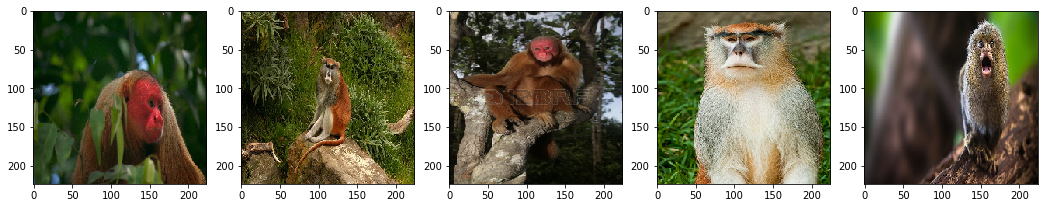

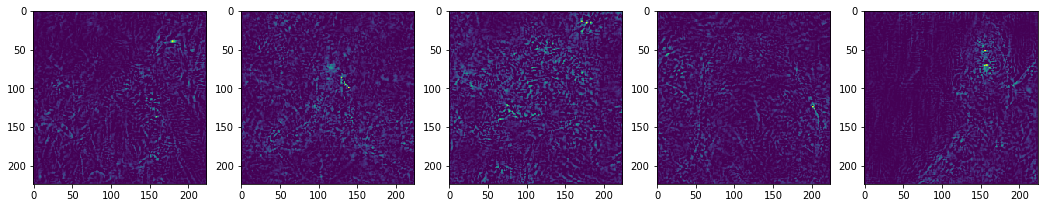

In [ ]:
saliency_visualization(train_generator)